# Plot $\tiny\Delta$TS result curves for all sources

This notebook demonstrates results of the profile likelihood scan for all considered sources and for two input models (Fig.11, 14, 15)
- purely leptonic emission with index **0.0**
- purely hadronic emission with index **1.0**

Since production of `numpy` takes a lot of time and computational resources, the final outcome of those files are combined in `csv` files,  
which are located in `/data/final_plots` folder.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


from scipy.integrate import quad
from scipy.optimize import curve_fit, newton
from scipy.interpolate import interp1d

from glob import glob
# from pathlib import Path
import os
import sys

sys.path.append("../src")
import plot_utils
from fill_table import *
import pandas as pd

from configure_analysis import AnalysisConfig
analysisconfig = AnalysisConfig()

%matplotlib inline
plot_utils.mpl_settings()

## Appendix: Scenarios for likelihood scan

The function `restore_param_values` is set up with the best-fit values from the Models notebook. This function sets the parameters of the PD and IC models to the initial values or in case hadronic and leptonic parameters are given it uses these parameters. It can also freeze the parameters of one of the models in case its amplitude is zero.

In the following a dictionary `prior_on_f` is defined with the keys `f` ($=f_0$), `f_err` ($=\Delta f$), `scale` and `power` which specifies the shape of the prior function. Then the data sets are read in and the models are initialized (note that the values of the parameters are not important as they are re-set by the restore_param_values function). The hadronic gamma-ray model and the neutrino model share the parameters of the proton spectrum. The parameter "beta" (the cutoff strength) is left free but bound between 0.5 and 2 (values >> 2 lead to problems in the numeric integration in the PD model).

Then the model's parameters are set to the initial values, assigned to the data sets and the data sets are "faked". That means that the counts cube of the data sets are filled with poisson randomized values based on the predicted counts (background + source prediction).

Having the randomized data, both models are fitted separately to the gamma-ray data first. This is done by using the `scipy` backend first which showed to find lower minima more consistently than the `minuit` backend. However it can not calculate the covariance matrix, so in a second step the models are fitted to the gamma-ray data again using `minuit` and starting with the scipy best-fit parameters. The now twice-optimized parameters including the uncertainties are stored and will be given to the restore_param_values function for the combined scans. For the PD model fit a `nuisance` dictionary is set up with the parameters and the errors which will be used for the *Scenario 2*.

For *Scenario 1*  
the PD and Inverse Compton (IC) model are fitted to the data with 21 ratios $f_0$ between 0 and 1 (called "values" in the script). The starting values for each fit are given by the pre-fitted values for each model where the amplitude is scaled according to $f_0$. This is important because the fit is rather sensitive to the starting parameters since the models are almost completely degenerate. After each optimization the total TS value and the integrals of the two models are stored. The integrals can be used to check if the fit maintained the correct ratio between the models since it has some freedom (${\small\Delta}  f$).

For *Scenario 2*  
the pion-decay model is fitted to the neutrino data where the parameters of the proton spectrum are constrained by a prior function to lie close to the parameters from the fit to the gamma-ray data. For each of the $f_0$ the amplitude (and error) of the model are scaled accordingly. After each optimization the total TS value and the integral of the PD gamma-ray model with the fitted neutrino parameters are stored.

For *Scenario 3*  
both models are fitted to both datasets simultaneously (also for each $f_0$ between 0 and 1). After each optimization the total TS value of each of the data sets is stored as well as the total TS value of the Fit (simply the sum of the individual TS values). The total TS values of the CTA data set can be compared to *Scenario 1* and the total TS values of the KM3NeT data set can be compared to *Scenario 2* since the TS values only depend on the model's parameters which are optimized according to each Scenario.

### Results per source

The main advantages of the combined analysis are the consistent treatment of the models which can become difficult for more complex models in the two separate analyses. And one could also evaluate the systematic uncertainties in a consistent way between the two analyses.

In the following the results for the individual sources are discussed:

- **Vela X** is a close-by pulsar wind nebula and most models assume a leptonic gamma-ray emission. None the less it is not
clear to what extent also protons contribute to the total gamma-ray flux from Vela X. In order to put strong constraints of the hadronic fraction it might be helpful to look for (the lack of) neutrinos coming from that source. It is also interesting to test the analysis in the case of a strong curved spectrum which can not be easily described by a pion-decay model. For the (unlikely) hadronic scenario CTA can hardly differentiate the two models whereas KM3NeT can, due to its high sensitivity to Vela X. For the leptonic scenario the two models are not very similar so CTA can differentiate between them much better. An interesting feature happens at high hadronic contributions, where the models of the separate analyses are fitted inconsistently even though resulting in the same ratio. For the combined analysis the models are further constrained which leads to higher TS-values.
- **RX J1713.7 $-$ 3946** is a young shell-type supernova remnant. The origin of the gamma-ray emission
extending up to about 100TeV is still unclear however molecular clouds in the vicinity of the source could be an indication for a hadronic production mechanism. Both instruments are less sensitive to this source than to Vela X which is why the discrimination power of the analysis is not as high. Since the spectrum of RX J1713.7-3946 can be described by a PD model as well as by a IC model it is difficult to only use gamma-ray data. This shows in the relatively flat ${\small\Delta} \mathrm{TS}$-curves for CTA.
- **Westerlund 1** is a massive young stellar cluster and also a PeVatron candidate. It is largely extended (~1 deg radius) and the origin of the emission is still unclear. The H.E.S.S. flux points do not constrain the cut-off in the electron/proton spectrum, so in principle several hypotheses could be tested here. We restrict ourselves to the best-fit models, which results in cut-offs in the primary spectra at around 1 PeV.
- **HESS J1908 $+$ 063** is an unassociated source where both a pulsar as well as a SNR are present. Gamma-ray emission above 100 TeV was detected by HAWC. For the leptonic scenario the discrimination power comes mostly from KM3NeT where as for the hadronic scenario the discrimination power comes mostly from CTA, because of the intrinsic curvature of the IC model.

In [2]:
data_path = analysisconfig.get_file("likelihood_analysis")

In [3]:
# list of source names in order to create all in one go
source_names = ["RXJ1713", "VelaX", "HESSJ1908", "Westerlund1"]

two possible option for the input emission model

In [4]:
leptonic = 0.0
hadronic = 1.0

model = hadronic

In [5]:
def process_data(data_path, source_name, model):
    file_path = os.path.join(data_path, f"{source_name}_{model}.csv")
    df = pd.read_csv(file_path)
    gdf = df.groupby(["seed", "case"])

    stat_tot = gdf["stat_total"].apply(lambda v: np.array(v)).unstack()
    TS1 = np.vstack(stat_tot[1])
    TS2 = np.vstack(stat_tot[2])
    TS3 = np.vstack(stat_tot[3])

    int_PD = gdf["int_PD"].apply(lambda v: np.array(v)).unstack()
    int_PD1 = np.vstack(int_PD[1])
    int_PD2 = np.vstack(int_PD[2])
    int_PD3 = np.vstack(int_PD[3])

    int_IC = gdf["int_IC"].apply(lambda v: np.array(v)).unstack()
    int_IC1 = np.vstack(int_IC[1])
    # int_IC2 = np.vstack(int_IC[2])
    int_IC3 = np.vstack(int_IC[3])

    TS_nu = gdf["stat_nu"].apply(lambda v: np.array(v)).unstack()
    TS3_nu = np.vstack(TS_nu[3])

    TS_gamma = gdf["stat_gamma"].apply(lambda v: np.array(v)).unstack()
    TS3_gamma = np.vstack(TS_gamma[3])

    TS1_avg = np.mean(TS1, axis=0)
    int_PD1_avg = np.mean(int_PD1, axis=0)
    int_IC1_avg = np.mean(int_IC1, axis=0)
    f1_avg = int_PD1_avg / (int_PD1_avg + int_IC1_avg)

    TS2_avg = np.mean(TS2, axis=0)
    f2_avg = np.mean(int_PD2, axis=0)

    TS3_avg = np.mean(TS3, axis=0)
    TS3_nu_avg = np.mean(TS3_nu, axis=0)
    TS3_gamma_avg = np.mean(TS3_gamma, axis=0)

    int_PD3_avg = np.mean(int_PD3, axis=0)
    int_IC3_avg = np.mean(int_IC3, axis=0)
    f3_avg = int_PD3_avg / (int_PD3_avg + int_IC3_avg)

    return (
        TS1,
        TS2,
        TS3,
        TS1_avg,
        TS2_avg,
        TS3_avg,
        TS3_avg,
        TS3_nu_avg,
        TS3_gamma_avg,
        f1_avg,
        f2_avg,
        f3_avg,
    )

In order to have the same ylim for leptonic and hadronic, it needs to set by the max of the limits

In [6]:
ylim_dct = {
    "HESSJ1908": (-1.777, 17.615),
    "Westerlund1": (-2.434, 30.003),
    "VelaX": (-4.864, 84.895),
    "RXJ1713": (-1.555, 17.866),
}

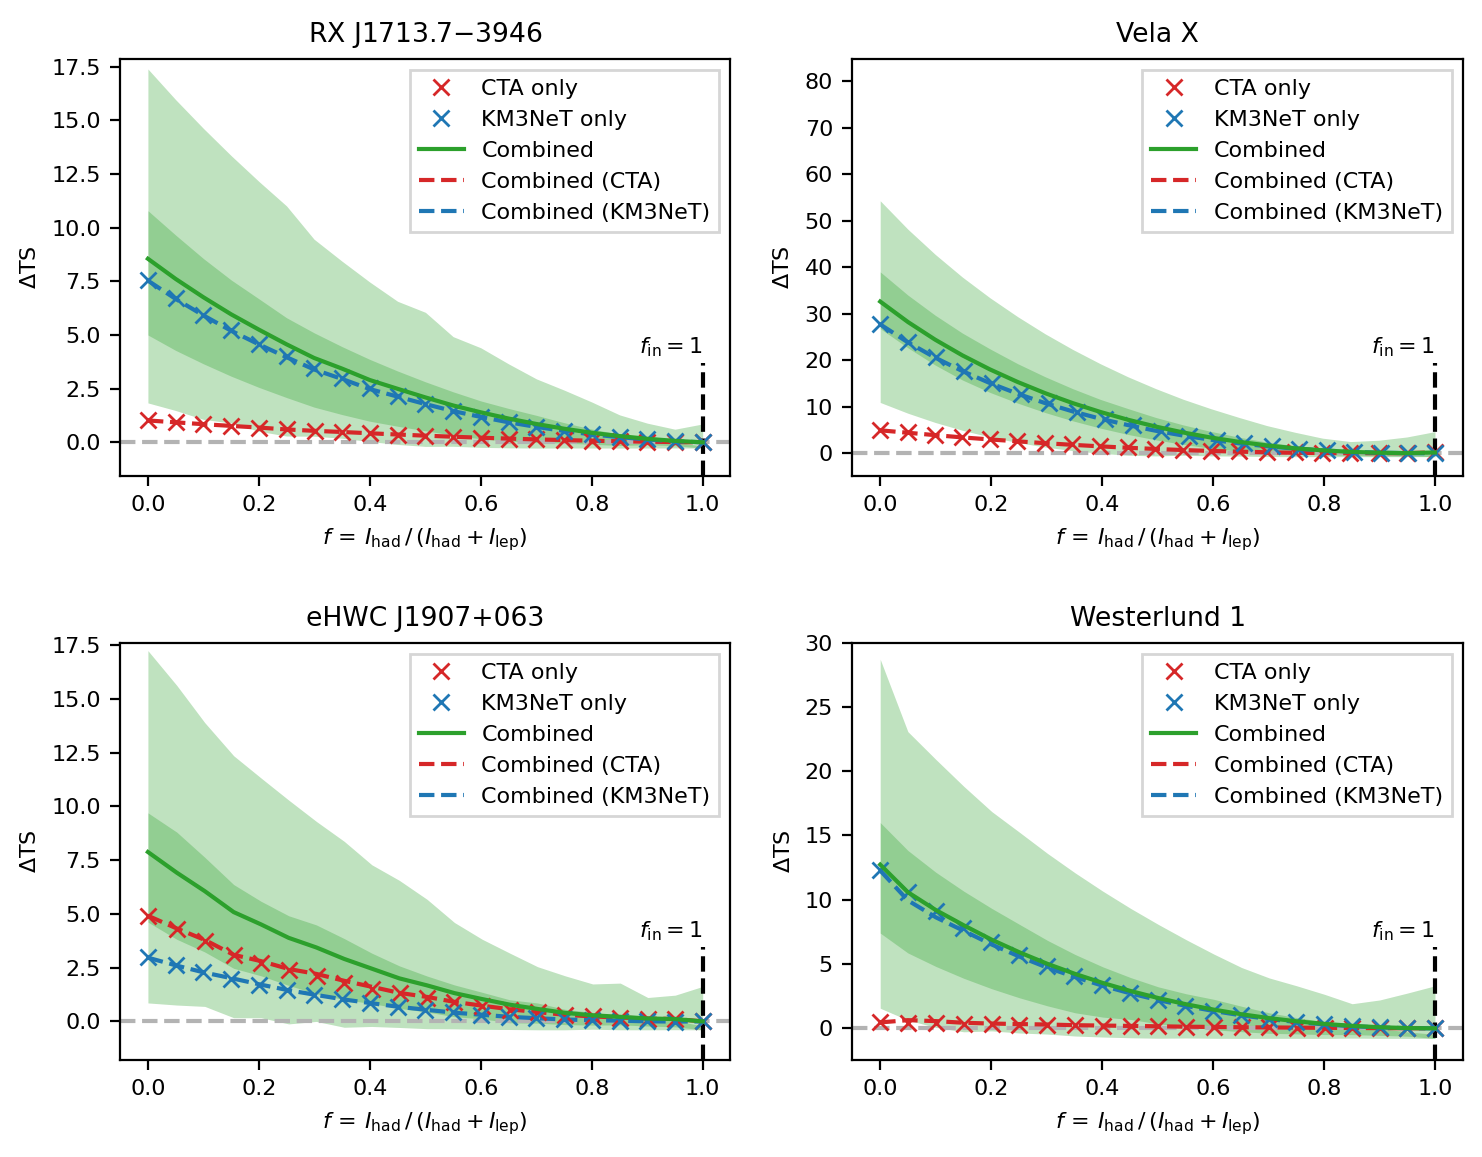

In [7]:
fig_width = 8.8 / 2.54
ax_width = 0.86
fig_height = 2.6
ax_height = fig_width * ax_width / 1.5 / fig_height

fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(2.5 * fig_width, 2.5 * fig_height), dpi=200
)
plt.subplots_adjust(hspace=0.4)


for ax, source_name_it in zip(axes.flat, source_names):
    (
        TS1,
        TS2,
        TS3,
        TS1_avg,
        TS2_avg,
        TS3_avg,
        TS3_avg,
        TS3_nu_avg,
        TS3_gamma_avg,
        f1_avg,
        f2_avg,
        f3_avg,
    ) = process_data(data_path=data_path, source_name=source_name_it, model=model)
    
    TS3_quantiles95 = np.quantile(TS3, [0.05, 0.95], axis=0)
    TS3_quantiles68 = np.quantile(TS3, [1 - 0.68, 0.68], axis=0)

    TS12_quantiles95 = np.quantile(np.array(TS1) + TS2, [0.05, 0.95], axis=0)
    TS12_quantiles68 = np.quantile(np.array(TS1) + TS2, [1 - 0.68, 0.68], axis=0)
    ax.set_title(plot_utils.source_name_labels[source_name_it])
    ax.set_xlabel("$f\,=\,I_\mathrm{had}\,/\,(I_\mathrm{had} + I_\mathrm{lep})$")
    ax.set_ylabel("$\Delta \mathrm{TS}$")

    idx_norm = TS3_avg.argmin()

    ax.plot(
        f1_avg,
        TS1_avg - TS1_avg[idx_norm],
        "x",
        c="tab:red",
        label="CTA only",
        zorder=4,
    )
    ax.plot(
        f2_avg,
        TS2_avg - TS2_avg[idx_norm],
        "x",
        c="tab:blue",
        label="KM3NeT only",
        zorder=4,
    )
    ax.plot(
        f3_avg,
        TS3_avg - TS3_avg[idx_norm],
        "-",
        c="tab:green",
        label="Combined",
        zorder=5,
    )
    ax.plot(
        f3_avg,
        TS3_gamma_avg - TS3_gamma_avg[idx_norm],
        "--",
        c="tab:red",
        label="Combined (CTA)",
        zorder=3,
    )
    ax.plot(
        f3_avg,
        TS3_nu_avg - TS3_nu_avg[idx_norm],
        "--",
        c="tab:blue",
        label="Combined (KM3NeT)",
        zorder=3,
    )

    ax.fill_between(
        f3_avg,
        TS3_quantiles95[0, :] - TS3_avg[idx_norm],
        TS3_quantiles95[1, :] - TS3_avg[idx_norm],
        color="tab:green",
        linewidth=0.0,
        alpha=0.3,
        zorder=1,
    )
    ax.fill_between(
        f3_avg,
        TS3_quantiles68[0, :] - TS3_avg[idx_norm],
        TS3_quantiles68[1, :] - TS3_avg[idx_norm],
        color="tab:green",
        linewidth=0.0,
        alpha=0.3,
        zorder=1,
    )

    ax.hlines(0, -0.05, 1.05, color="0.7", ls="--", zorder=2)
    ax.axvline(model, ymax=0.27, color="k", ls="--", zorder=2)
    trans = plt.matplotlib.transforms.blended_transform_factory(
        ax.transData, ax.transAxes
    )
    ha_dict = {0.0: "left", 0.5: "center", 1.0: "right"}
    ax.text(
        model,
        0.28,
        "$f_\mathrm{{in}} = {:g}$".format(model),
        ha=ha_dict[model],
        va="bottom",
        color="k",
        transform=trans,
    )
    y1, y2 = ax.get_ylim()

    ax.set_xlim(-0.05, 1.05)
    if source_name_it in ylim_dct.keys():
        ax.set_ylim(ylim_dct[source_name_it])

    leg_loc = {0.0: "upper left", 0.5: "upper center", 1.0: "upper right"}
    ax.legend(loc=leg_loc.get(model, "upper left"))

plt.show()

To save figures locally

In [8]:
for form in ['png', 'pdf']:
    fig.savefig(analysisconfig.get_file("likelihood_analysis/plots/all_sources_scan_"+str(model)+"."+form))